In [151]:
import os, sys
import numpy as np
import pandas as pd
from typing import Union

import matplotlib.pyplot as plt
import seaborn as sb

import ipywidgets as widgets
from IPython.display import display

In [152]:
sb.set_context(
    "talk",
    font_scale=1.2
)

sb.set_style(
    "darkgrid"
)

layout = widgets.Layout(
            width="50%"
         )

style  = {"description_width": "initial"}

In [153]:
# Physical constants for parametric analysis
kCu = 398.0 # W/mK
kAl = 180.0 # W/mK
kSteel = 14.0 # W/mK

hNaturalConv = 5.0 # W/m2K
hForcedConv  = 1000.0 # W/m2K

In [154]:
# Sliders for interactive plots 
thermalCondSlider = widgets.FloatSlider(
    value=kCu,
    min=kSteel,
    max=kCu,
    step=(kCu - kSteel)/100,
    description="k (W/mK)",
    readout_format='.1f',
    layout=layout,
    style=style
)

htcSlider = widgets.FloatSlider(
    value=htc,
    min=hNaturalConv,
    max=hForcedConv,
    step=(hForcedConv - hNaturalConv)/500,
    description="h (W/m2K)",
    readout_format='.1f',
    layout=layout,
    style=style
)

In [155]:
def temperatureFinActiveBoundary(
        length: float,
        htc: float,
        k: float,
        perimeter: float,
        area_tr: float,
        Tinf: float,
        Tbase: float
    )   -> float:
    
    # This function must return an array
    xRange = np.linspace(0.0, length, 100)
                    
    thetaB = diffTemp(Tbase, Tinf)
    
    m = mCoeffFin(
            htc,
            k,
            perimeter,
            area_tr
        )
    
    M = MCoeffFin(
            htc,
            k,
            perimeter,
            area_tr,
            Tinf,
            Tbase
        )
    
    arg   = m*(length - xRange)
    coeff = htc/(m*k)
    
    thetaRatio = (
                     np.cosh(arg) + coeff*np.sinh(arg)
                 )/(
                     np.cosh(m*length) + coeff*np.sinh(m*length)
                 )
    
    return Tinf + thetaRatio*thetaB

def temperatureFinInfLength(
        x: float,
        htc: float,
        k: float,
        perimeter: float,
        area_tr: float,
        Tinf: float,
        Tbase: float
    )   -> float:
                         
    thetaB = diffTemp(Tbase, Tinf)
    
    m = mCoeffFin(
            htc,
            k,
            perimeter,
            area_tr
        )
    
    return Tinf + thetaB*np.exp(-m*x)

In [156]:
def heatTransferFinActiveBoundary(
        length: float,
        htc: float,
        k: float,
        perimeter: float,
        area_tr: float,
        Tinf: float,
        Tbase: float
    )   -> float:
    
    m = mCoeffFin(
            htc,
            k,
            perimeter,
            area_tr
        )
    
    M = MCoeffFin(
            htc,
            k,
            perimeter,
            area_tr,
            Tinf,
            Tbase
        )
    
    coeff = htc/(m*k)
    
    return M*(
                np.sinh(m*length) + coeff*np.cosh(m*length)
           )/(
                np.cosh(m*length) + coeff*np.sinh(m*length)
           )

def heatTransferFinInfLength(
        htc: float,
        k: float,
        perimeter: float,
        area_tr: float,
        Tinf: float,
        Tbase: float
    )   -> float:
                         
    
    M = MCoeffFin(
            htc,
            k,
            perimeter,
            area_tr,
            Tinf,
            Tbase
        )
    
    return M

In [157]:
def finEfficiency(
        length: float,
        htc: float,
        k: float,
        perimeter: float,
        area_tr: float,
        Tinf: float,
        Tbase: float,
        fin_area: float
    )   -> float:
    
    qa = heatTransferFinActiveBoundary(
            length=length,
            htc=htc,
            k=k,
            perimeter=perimeter,
            area_tr=area_tr,
            Tinf=Tinf,
            Tbase=Tbase
        )
    
    return qa/(htc*fin_area*diffTemp(Tbase,Tinf))

In [158]:
class FinUniformAtr():
    
    def __init__(
            self,
            htc: float,
            k: float,
            Tinf: float,
            Tbase: float
        ):
        """Initiate fin geometric model."""
        
        self._h = htc
        self._k = k
        self._Tinf = Tinf
        self._Tbase = Tbase
        
        self._thetaB = Tbase - Tinf
       
    def mCoeffFin(self):
        return np.sqrt(
                   self._h*self._perimeter/(self._k*self._area_tr)
               )
        
    def MCoeffFin(self):
        return np.sqrt(
                   self._h*self._perimeter*self._k*self._area_tr
               )*self._thetaB
    
    def temperatureDistribution(self):
        """Compute temperature distribution in a planar fin."""
        
        return temperatureFinActiveBoundary(
                    length=self._L,
                    htc=self._h,
                    k=self._k,
                    perimeter=self._perimeter,
                    area_tr=self._area_tr,
                    Tbase=self._Tbase,
                    Tinf=self._Tinf
                )

    def heatTransfer(self):
        
        # By using the equivalent length
        # the heat transfer can be approximated
        # by the equation for the adiabatic tip
        return self._M*np.tanh(self._m*self._Lc)
            
    def efficiency(self):
        
        qMax = self._h*self._area_fin*self._thetaB
        
        return self.heatTransfer()/qMax
    
    def effectiveness(self):
        
        qBaseNoFin = self._h*self._area_tr*self._thetaB
        
        return self.heatTransfer()/qBaseNoFin
    
    def getLength(self):
        """Get fin length."""
        
        return self._L
              
    def getPerimeter(self):
        """Get fin perimeter."""
        
        return self._perimeter
    
    def getSurfaceArea(self):
        """Get fin surface area."""
        
        return self._area_fin
    
    def getTrArea(self):
        """Get fin section area."""
        
        return self._area_tr

In [159]:
class PlanarFin(FinUniformAtr):
    
    def __init__(
            self,
            length: float,
            width: float,
            thickness: float,
            htc: float,
            k: float,
            Tinf: float,
            Tbase: float
        ):
        """Initiate fin geometric model."""
        
        FinUniformAtr.__init__(
            self,
            htc=htc,
            k=k,
            Tbase=Tbase,
            Tinf=Tinf
        )
        
        # Rectangular planar fin 
        self._L = length
        self._w = width
        self._t = thickness
        
        # Equivalent length to compute efficiency
        self._Lc = self._L + 0.5*self._t
        
        self._perimeter = 2*self._w + 2*self._t
        self._area_fin  = self._Lc*self._perimeter
        self._area_tr   = self._w*self._t
        self._area_prof = self._t*self._L
        
        # Their computattion depends on the geometry
        self._m = self.mCoeffFin()
        self._M = self.MCoeffFin()

In [160]:
class PiniformFin(FinUniformAtr):
    
    def __init__(
            self,
            length: float,
            diameter: float,
            htc: float,
            k: float,
            Tinf: float,
            Tbase: float
        ):
        """Initiate fin geometric model."""
        
        FinUniformAtr.__init__(
            self,
            htc=htc,
            k=k,
            Tbase=Tbase,
            Tinf=Tinf
        )
            
        # Rectangular piniform fin test
        self._L = length
        self._D = diameter
        
        # Equivalent length to compute efficiency
        self._Lc = self._L + 0.25*self._D
        
        self._perimeter = np.pi*self._D
        self._area_fin  = self._Lc*self._perimeter
        
        self._area_tr   = 0.25*np.pi*self._D**2
        self._area_prof = self._D*self._L
        
        # Their computattion depends on the geometry
        self._m = self.mCoeffFin()
        self._M = self.MCoeffFin()

In [161]:
class TriangularFin():
    
    def __init__(
            self,
            length: float,
            width: float,
            thickness: float,
            htc: float,
            k: float,
            Tinf: float,
            Tbase: float
        ):
        """Initiate fin geometric model."""
        
        FinUniformAtr.__init__(
            self,
            htc=htc,
            k=k,
            Tbase=Tbase,
            Tinf=Tinf
        )
        
        # Rectangular planar fin 
        self._L = length
        self._w = width
        self._t = thickness
        
        # These two change with x
        self._perimeter = 2*self._w + 2*self._t
        self._area_tr   = self._w*self._t
        
        # Areas
        self._area_fin  = 2*self._w*np.sqrt(
                                self._L**2 + 0.25*self._t**2
                            )
        
        self._area_prof = self._t*self._L
        
        # Their computattion depends on the geometry
        # These two have to be defined here
        self._m = self.mCoeffFin()
        self._M = self.MCoeffFin()

## Análise do Exemplo 3.9 Item 1 do Livro-texto

Um bastão muito longo, com 5 mm de diâmetro, tem uma de suas extremidades mantida a 100 °C. A superfície do bastão está exposta ao ar ambiente a 25 °C, com um coeficiente de transferência de calor por convecção de 100 $W/(m^2·K)$.

1. Determine as distribuições de temperaturas ao longo de bastões construídos em cobre puro, liga de alumínio 2024 e aço inoxidável AISI 316. Quais são as respectivas taxas de perda de calor nos bastões?

In [129]:
# Dados do problema
exHtc   = 100.0 # W/m2K
exTbase = 100.0 # Celsius
exTinf  = 25.0 # Celsius

# Dimensions
exFinRadius = 2.5e-3 # meters

Vamos supor um comprimento $L = 300 mm$ para esta aleta para avaliarmos o campo de temperatura na mesma.

In [130]:
finLength = 0.3 # meters

A implementação feita aqui usa classes em Python para encapsular todas as operações necessárias para estudarmos aletas. Podemos instanciar um objeto da classe "PiniformFin" (aleta piniforme com área de seção uniforme) e informar as grandezas da mesma.

Apenas como exemplo do tipo de interação possível, vamos instanciar um objeto de aleta com a condutividade do cobre. Todas as grandezas devem ser dadas em unidades do SI, com exceção da temperatura que pode ser informada em graus Celsius.

In [133]:
pinFin = PiniformFin(
            length=finLength,
            diameter=2*finRadius,
            htc=exHtc,
            k=kCu,
            Tinf=exTinf,
            Tbase=exTbase
       )

Agora podemos acessar as grandezas da mesma usados suas chamadas "funções membro", como segue: 

In [139]:
# Area da superfície
pinFin.getSurfaceArea() 

0.004732023934469626

In [141]:
# Perímetro
pinFin.getPerimeter() 

0.015707963267948967

In [143]:
# Area da seção transversal
pinFin.getTrArea()

1.9634954084936207e-05

In [145]:
# Taxa total de transf. de calor (W)
pinFin.heatTransfer()

8.306311707704959

In [146]:
# Effetividade
pinFin.effectiveness()

56.40493086478194

In [147]:
# Efficiency
pinFin.efficiency()

0.2340453562854022

Vamos agora à comparação da distribuição de temperaturas para os 3 casos de materias considerados da aleta piniforme. Bastar executar o código a seguir. A efetividade de cada caso é mostrada na legenda da figura.

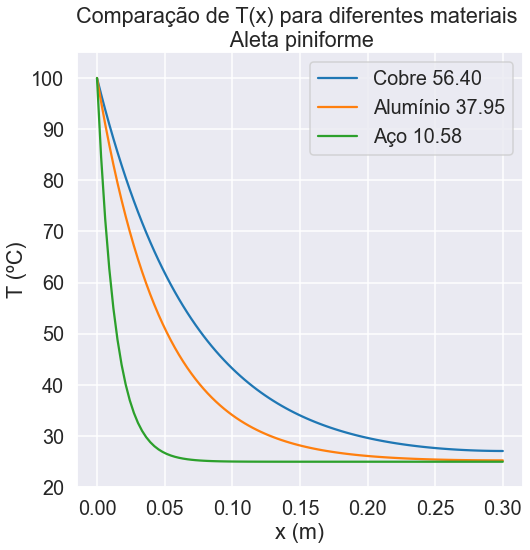

In [176]:
fig, axes = plt.subplots(
                figsize=(8,8)
            )

for k, label in zip([kCu, kAl, kSteel],
                    ["Cobre", "Alumínio", "Aço"]):
    
    # Instantiate piniform fin model
    pinFin = PiniformFin(
                 length=finLength,
                 diameter=2*exFinRadius,
                 htc=exHtc,
                 k=k,
                 Tinf=exTinf,
                 Tbase=exTbase
             )

    # Get temperature distribution
    pinTemp = pinFin.temperatureDistribution()
    
    xRange = np.linspace(
                    0.0,
                    pinFin.getLength(),
                    len(pinTemp)
            )

    sb.lineplot(
        x=xRange,
        y=pinTemp,
        label=f"{label} {pinFin.effectiveness():.2f}",
        ax=axes
    )

    axes.set(
        ylabel="T (ºC)",
        xlabel="x (m)",
        title="Comparação de T(x) para diferentes materiais \n Aleta piniforme",
        ylim=(20,105)
    )

Claramente a efetividade da aleta de aço é menor, o que é esperado. A efetividade da aleta é melhorada quando selecionamos um material com maior condutividade térmica.

Uma versão interativa deste gráfico pode ser encontrado com o código a seguir. Use os "sliders" para controlar o valor:

1. da condutividade térmica;
2. do coef. de transferência de calor por conveccção;
3. e do raio da aleta.

In [177]:
pinRadiusSlider = widgets.FloatSlider(
    value=exFinRadius,
    min=exFinRadius,
    max=5.0*finRadius,
    step=exFinRadius/100,
    readout_format='.2e',
    layout=layout,
    style=style,
    description="R (m)"
)

@widgets.interact(
    k=thermalCondSlider,
    h=htcSlider,
    R=pinRadiusSlider
)
def InteractiveTempFin(
        k,
        h,
        R
    ):
    
    fig, axes = plt.subplots(
                    figsize=(8,6)
                )
    
    pinFin = PiniformFin(
                 length=finLength,
                 diameter=2*R,
                 htc=h,
                 k=k,
                 Tinf=Tinf,
                 Tbase=Tbase
             )

    pinTemp = pinFin.temperatureDistribution()
    
    xRange = np.linspace(
                    0.0,
                    pinFin.getLength(),
                    len(pinTemp)
            )

    sb.lineplot(
        x=xRange,
        y=pinTemp,
        ax=axes
    )

    axes.text(
        0.32, 100,
        f"Heat transfer = {pinFin.heatTransfer():.2f} W\n"\
        f"Efetividade = {pinFin.effectiveness():.2f}\n"\
        f"Eficiência = {pinFin.efficiency():.2f}",
        ha = "left",
        va = "top"
    )

    axes.set(
        ylabel="T (ºC)",
        xlabel="x (m)",
        title="Comparação de T(x) para diferentes materiais \n Aleta piniforme",
        ylim=(20,105)
    )

interactive(children=(FloatSlider(value=398.0, description='k (W/mK)', layout=Layout(width='50%'), max=398.0, …

## Desempenhos de Aletas

Note que para um comprimento de aproximadamente $L \approx 60mm$ da aleta de aço a aleta não troca mais calor e o resot de material é inútil em vista de sua aplicação. Este valor pode ser obtido ao se comparar a taxa de trans. de calor total da aleta com o modelo de comprimento infinito e o modelo de fronteira adiabática, pois em uma aleta com um comprimento muito longo não há mais troca de calor na sua extremidade. Assim, com esta comparação, podemos avaliar a partir de qual comprimento o modelo de aleta infinita é válido. Comparando as equações (3.81) e (3.85), podemos escrever:

\begin{equation}
    \tanh{mL} \ge 0.99
\end{equation}

O que leva a (podemos resolver esta equação usando a definição da tangente hiperbólica):

\begin{equation}
    mL \ge 2.65
    \rightarrow
    L \ge \frac{2.65}{m}
\end{equation}

sendo $m = \sqrt{\frac{hP}{kA_{tr}}}$. Assim, na prática, o comprimento das aletas deve ser menor que aproximadamente $\frac{2.65}{m}$ pois a partir desse comprimento ela não troca calor mais. No caso do problema do livro:

In [179]:
for k, mat in zip([kCu, kAl, kSteel],
                  ["Cobre", "Al", "Aço"]):
    fin = PiniformFin(
                length=finLength,
                diameter=2*exFinRadius,
                htc=exHtc,
                k=k,
                Tinf=exTinf,
                Tbase=exTbase
            )
    
    print(
        f"{mat} -> L >= {2.65/fin.mCoeffFin():.3f} m"
    )

Cobre -> L >= 0.187 m
Al -> L >= 0.126 m
Aço -> L >= 0.035 m


Além disso, note que a efetividade e eficiência da aleta aumetam conforma k aumenta e h diminui. Se aumentarmos o raio da aleta piniforme, aumentamos ainda mais a eficiência mas a efetividade começa a diminuir! Estes efeitos são esperados.

Como vimos em aula, a partir da definição da efetividade e assumindo um modelo de aleta infinita, então podemos mostrar que a efetividade de aletas de seção uniforme é dada por:

\begin{equation}
    \epsilon_a
    =
    \left(
        \frac{
            kP
        }{
            hA_{tr}
        }
    \right)^{\frac{1}{2}}
\end{equation}

Assim, a efetividade:

1. aumenta com um valor maior de k;
2. diminui com um valor maior de h;
3. Aumenta com uma maior valor da razão $\dfrac{P}{A_{tr}}$

No caso de aleta piniforme:

\begin{equation}
    \frac{P}{A_{tr}}
    =
    \frac{
        2\pi R
    }{
        \pi R^2
    }
    =
    \frac{2}{R}
\end{equation}

Logo, quanto menor o raio da aleta piniforme, realmente maior vai ser sua efetividade. 

No caso de aletas planas retangulares, temos o seguinte:

\begin{equation}
    \frac{P}{A_{tr}}
    =
    \frac{
        2(w + t)
    }{
        wt
    }
    =
    \frac{
        2\left(1 + \dfrac{t}{w}\right)
    }{
        t
    }
\end{equation}

Assim, se $w \gg t$, quanto menor for a espessura da aleta melhor, pois sua efetividade aumentará.

In [181]:
# Adding a similar planar fin
exFinWidth = 0.20
exFinThickness = 0.01

planarFin = PlanarFin(
                length=finLength,
                width=exFinWidth,
                thickness=exFinThickness,
                htc=htc,
                k=kCu,
                Tinf=Tinf,
                Tbase=Tbase
           )

In [183]:
localRadiusSlider = widgets.FloatSlider(
    value=finRadius,
    min=finRadius,
    max=5.0*finRadius,
    step=finRadius/100,
    readout_format='.2e',
    layout=layout,
    style=style
)

@widgets.interact(R=localRadiusSlider)
def InteractiveCompareFinSizes(
        R
    ):

    fig, ax = plt.subplots()
    
    planarTemp = planarFin.temperatureDistribution()
    
    pinFin = PiniformFin(
                length=0.3,
                diameter=2*R,
                htc=htc,
                k=kCu,
                Tinf=Tinf,
                Tbase=Tbase
           )

    pinTemp = pinFin.temperatureDistribution()

    xRange = np.linspace(
                    0.0,
                    pinFin.getLength(),
                    len(pinTemp)
            )

    sb.lineplot(
        x=xRange,
        y=pinTemp,
        ax=ax,
        label="Piniform"
    )

    sb.lineplot(
        x=xRange,
        y=planarTemp,
        ax=ax,
        label="Planar"
    )
    
    ax.set(
        ylabel="Temperature (ºC)",
        xlabel="x (m)",
        title="What radius a piniform fin must have \n to compare with a planar one?",
        ylim=(Tinf, Tbase)
    )

interactive(children=(FloatSlider(value=0.0025, description='R', layout=Layout(width='50%'), max=0.0125, min=0…

In [184]:
@widgets.interact(
    k=thermalCondSlider,
    h=htcSlider
)
def InteractiveTempFin(
        k,
        h
):
    
    fig, axes = plt.subplots(
                    figsize=(10,8)
                )

    lengths = np.linspace(0,0.50,50)

    planarEfficiencies = [PlanarFin(
                                 length=L,
                                 width=0.2,
                                 thickness=0.01,
                                 htc=h,
                                 k=k,
                                 Tinf=Tinf,
                                 Tbase=Tbase
                             ).efficiency() 
                            for L in lengths]


    pinEfficiencies = [PiniformFin(
                             length=L,
                             diameter=2.0*finRadius,
                             htc=h,
                             k=k,
                             Tinf=Tinf,
                             Tbase=Tbase
                         ).efficiency() 
                        for L in lengths]

    sb.lineplot(
        x=lengths,
        y=planarEfficiencies,
        label="Planar",
        ax=axes
    )

    sb.lineplot(
        x=lengths,
        y=pinEfficiencies,
        label="Piniform",
        ax=axes
    )

    axes.set(
        title="Effect of h and k on fin efficiency",
        ylabel="Efficiency",
        xlabel="L (m)",
        ylim=(0.0,1.05)
    )

interactive(children=(FloatSlider(value=398.0, description='k (W/mK)', layout=Layout(width='50%'), max=398.0, …